# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов. Вы будете классифицировать тексты писателей по авторству. Всего 8 разных авторов.

Скачаем датасет:

In [1]:
!wget -O train_authors.csv https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/train_authors_new.csv

--2025-04-13 11:58:57--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/train_authors_new.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5163531 (4.9M) [text/plain]
Saving to: ‘train_authors.csv’

train_authors.csv   100%[===================>]   4.92M  19.8MB/s    in 0.2s    

2025-04-13 11:58:57 (19.8 MB/s) - ‘train_authors.csv’ saved [5163531/5163531]



In [2]:
!wget -O test_authors.csv https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/test_authors_new.csv

--2025-04-13 11:58:57--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/test_authors_new.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 961703 (939K) [text/plain]
Saving to: ‘test_authors.csv’

test_authors.csv    100%[===================>] 939.16K  --.-KB/s    in 0.02s   

2025-04-13 11:58:57 (43.3 MB/s) - ‘test_authors.csv’ saved [961703/961703]



Импортируем необходимые библиотеки:

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from tqdm import tqdm_notebook
import torch.nn as nn                                                             # тут все блоки нейронных сетей, слои
import torch.nn.functional as F

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

# скачиваем нужный пакет данных для работы библиотеки nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Загрузим даатсет и посмотрим на данные:

In [5]:
# Загрузим датасет
import pandas as pd
train_data = pd.read_csv('train_authors.csv')
train_data.head()

,text,author
0,"Студент, который все это нам рассказал, прилет...",Bulychev
1,"-Что не укладывается в голове,- произнес отец ...",Pratchett
2,"-Ш-ш-ш,- сказал я.- Спи.\n-Не могу,- ответила ...",King
3,-В Севастополь? Новое задание имеет отношение ...,Akunin
4,"-Ты прав,- сказал Сева.- Даже если это космиче...",Bulychev


Здесь поле 'text' — это текст, а 'author' — автор текста. 'author' — это целевая переменная, которую мы будем предсказывать. Обратите внимания, что в тестовых данных столбца 'author' нет, вам нужно будет предсказать его значения и отправить в качестве ответа на Яндекс.Контест.

In [6]:
test_data = pd.read_csv('test_authors.csv')
test_data.head()

,text
0,-Не выглядывал еще. Дрыхнет… Почему да почему?...
1,"Идти ему было немного; он даже знал, сколько ш..."
2,Придется вернуться в самое изголовье и начать ...
3,"-С ума сойти,- сказал отец. Он обернулся, увид..."
4,"Во-вторых, положение Петра после захвата власт..."


Заведем словарь соответствия имени автора его номеру:

In [7]:
writers = ['Akunin', 'Bulychev', 'Chehov', 'Dostoevsky', 'Gogol', 'King',
       'Pratchett', 'Remark']
writers_to_label = {writer: i for i, writer in enumerate(writers)}
label_to_writers = {i: writer for i, writer in enumerate(writers)}

Создадим словарь dataset, который будет устроен так же, как переменная dataset в ноутбуке занятия. В тестовой части (dataset['test']) зададим для удобства всем текстам author=0.

In [8]:
dataset = {}

dataset['train'] = [{'text':text, 'author':writers_to_label[label]} \
              for text, label in zip(np.array(train_data['text']), np.array(train_data['author']))]
dataset['test'] = [{'text':text, 'author': 0} \
              for text in np.array(test_data['text'])]

Ваша задача — обучить RNN-модель на тренировочных данных и получить максимальное возможное accuracy на тестовой части данных. За основу можно взять код с занятия. **Обратите внимание, что здесь у нас задача классификации на 8 классов, а не на 2, как было на занятии.**

Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Вот несколько идей:
* **Модель RNN**. Попробуйте LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение вида агрреграции выхода RNN**. В семинаре мы пробовали аггрегировать выходы RNN с помощью max, mean и получения последнего выхода. Можно попробовать другие варианты. Например, конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Можно, например, увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

## Сдача задания

Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы получить предсказания на тестовой выборке. Здесь model — ваша обученная модель, dataloader — test_dataloader, построенный на основе тестовой части данных (dataset['test']):

In [9]:
# библиотека для работы со строками. С ее помощью мы удалим знаки препинания
import string
# счетчик для создания счетчика слов
from collections import Counter
# библиотека, с помощью которой разобьем текст на токены
import nltk
from nltk.tokenize import word_tokenize

# скачиваем нужный пакет данных для работы библиотеки nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# функция для обработки предложения
def process_and_tokenize_text(text):
    # приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = text.lower().translate(
        str.maketrans('', '', string.punctuation)
    )
    # токенизируем текст
    tokens = word_tokenize(prccessed_text)
    return tokens

# массивы для хранения токенизированных тренировочных и тестовых данных
train_data = []
test_data = []

# пустой счетчик слов
words = Counter()

# проходимся по текстам обучающего датасета и предобрабатываем их
for example in tqdm_notebook(dataset['train']):
    text = example['text']
    label = example['author']
    text_processed = process_and_tokenize_text(text)
    train_data.append((text_processed, label))

    # увеличиваем счетчик каждого слова в словаре
    for word in text_processed:
        words[word] += 1

# проходимся по текстам тестового датасета и предобрабатываем их
for example in tqdm_notebook(dataset['test']):
    text = example['text']
    label = example['author']
    text_processed = process_and_tokenize_text(text)
    test_data.append((text_processed, label))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-9-592f696dcda2>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(dataset['train']):


  0%|          | 0/1734 [00:00<?, ?it/s]

<ipython-input-9-592f696dcda2>:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(dataset['test']):


  0%|          | 0/330 [00:00<?, ?it/s]

In [10]:
# создаем словарь как множество слов
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
# будем добавлять в словарь только те слова, которые
# встречались в обучающих данных не менее 25 раз
counter_threshold = 20

# пополняем словарь словами из words
for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [11]:
len(vocab)

2002

In [12]:
word2ind = {token: i for i, token in enumerate(vocab)}
ind2word = {i: token for token, i in word2ind.items()}

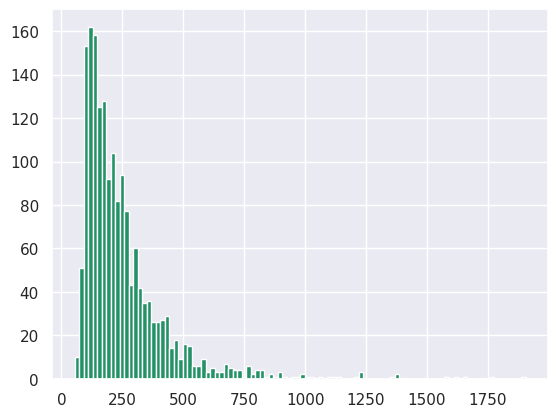

In [13]:
plt.hist([len(x[0]) for x in train_data], bins=100);

In [41]:
def collate_fn_with_padding(input_batch, max_len=256):
    # input_batch — батч пар (токенизированный текст, label)
    texts = [x[0] for x in input_batch]
    labels = [x[1] for x in input_batch]
    # для каждого элемента батча получаем длину токенизированного текста в токенах
    seq_lens = [len(x) for x in texts]
    # определяем максимальную длину элементов в текущем батче
    max_seq_len = min(max(seq_lens), max_len)

    # проходимся по элементам батча и заменяем токены на их индексы из словаря
    # также последовательности короче max_seq_len дополняем токенами <pad>
    processed_texts = []
    for text, label in zip(texts, labels):
        text = text[:max_seq_len]
        text = [word2ind[x] if x in vocab else word2ind['<unk>'] for x in text]
        for _ in range(max_seq_len - len(text)):
            text.append(word2ind['<pad>'])

        processed_texts.append(text)

    # переводим элементы батча в форматы тензоров
    processed_texts = torch.LongTensor(processed_texts).to(device)
    labels = torch.LongTensor(labels).to(device)

    # собираем батч
    processed_batch = {
        'input_ids': processed_texts,
        'author': labels
    }

    return processed_batch

In [42]:
(len(test_data))

330

In [43]:
# поделим тестовые данные на val и test
# np.random.seed(42)
# val_indices = np.random.choice(np.arange(len(test_data)), 30)
# test_indices = [x for x in range(len(test_data)) if x not in val_indices]
# val_data = [test_data[i] for i in val_indices]
# test_data = [test_data[i] for i in test_indices]



# заводим даталоадеры
batch_size = 128
train_dataloader = DataLoader(
    train_data, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# val_dataloader = DataLoader(
#     test_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [44]:
print(len(test_dataloader))

3


In [45]:
class SimpleRNN(nn.Module):
    def __init__(
        self, hidden_dim, vocab_size, num_classes,
        aggregation_type: str = 'last'
        ):
        super().__init__()
        # слой эмбеддинга
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # рекуррентный слой
        # Параметры - размер эмбеддингов токенов, размер вектора скрытого состояния, формат представления данных в батче
        # self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # # два полносвязных слоя
        # self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, num_classes)

        # # слой дропаут
        # self.dropout = nn.Dropout(p=0.1)

        self.rnn = nn.GRU(hidden_dim, hidden_dim,
                         num_layers=2,
                         bidirectional=True,  # Добавляем двунаправленность
                         dropout=0.1,
                         batch_first=True)
        # Увеличиваем глубину FC слоев
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),  # *2 для bidirectional
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

        # каким образом выходы RNN-слоя для разных моментов времени будут
        # агрегироваться перед подачей дальше на вход полносвязному слою
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)          # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]         #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)           #[batch_size, hidden_dim]
        elif self.aggregation_type == 'last':
            output = output[:, -1, :]
        else:
            raise ValueError("Invalid aggregation_type")

        output = F.tanh(output)
        # output = F.tanh(self.dropout(self.fc1(output)))   # [batch_size, hidden_dim]
        # output = self.fc2(output)                         # [batch_size, num_classes]
        output = self.fc(output)

        return output

In [46]:
import tqdm.notebook

In [47]:
def evaluate(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in tqdm.notebook.tqdm(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['author'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [48]:
def train(model, optimizer, criterion, num_epoch=5, eval_steps=100):

    losses = []
    accs_train = []
    accs_val = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm.notebook.tqdm(train_dataloader,
                                                desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['author'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                # accs_train.append(evaluate(model, train_dataloader))
                # accs_val.append(evaluate(model, val_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return model

In [60]:
eval_steps = len(train_dataloader) // 2


aggregation_type = 'mean'
losses = []
acc = []

model = SimpleRNN(hidden_dim=300,
                  vocab_size=len(vocab),
                  num_classes=8,
                  aggregation_type=aggregation_type
                  ).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

model = train(model,
                                      optimizer,
                                      criterion,
                                      num_epoch=8,
                                      eval_steps=len(train_dataloader) // 2)

Training epoch 0::   0%|          | 0/14 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/14 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/14 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/14 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/14 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/14 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/14 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/14 [00:00<?, ?it/s]

In [63]:
def get_predictions(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))

    predictions = torch.cat(predictions).data.cpu().numpy()

    return predictions

In [64]:
predictions = get_predictions(model, test_dataloader)
predictions = [label_to_writers[x] for x in predictions]


<ipython-input-63-5a7bf3723a28>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader,


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

In [65]:
np.save('submission_hw07.npy', predictions, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw07.npy`')

Ответ сохранен в файл `submission_hw07.npy`
